In [1]:
##This code is for 1 Hz n s files. For 1 Hz 1s files, use 20200818 code, where fitting works

In [2]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later

import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import load_dir

In [3]:
# calibration of the voltage - position conversion
def voltage_to_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

In [4]:
from scipy.optimize import curve_fit
from scipy.stats import norm

In [5]:
# load the data
Year = "2020"
Month = "12"
Day = "15"
BeadNumber = 1
#RunNumber = 144
#folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/Bead"+str(BeadNumber)+"/Shaking/"
#folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/Bead"+str(BeadNumber)+"/BeamProfile/"
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day + "/BeamProfile/"
#folder =  r"/data/new_trap/" + Year + Month + Day + "/Bead1/Shaking/BeamProfile/"
#folder=r"/data/new_trap/20201210/"

In [168]:
Fname="BeamProfileX20"
files = load_dir(folder, file_prefix = Fname, max_file=500)

100%|██████████| 91/91 [00:06<00:00, 14.09it/s]

91  files in folder
91  files loaded


In [169]:
def get_waist(pos,pd, flip=False):

    pos1 = voltage_to_position(pos)
    if (flip):
        pos1 *= -1
    data1 = np.array(pd)-np.min(pd)
    data1 = data1/np.max(data1)    
    #noraml CDF fit
    temp_params = curve_fit(norm.cdf, pos1, data1, p0=[pos1[2500],5])[0]
    
    if (flip):
        temp_params[0] *= -1
    return temp_params

In [170]:
#10 data points
parX1 = []
parX2 = []
spin=np.zeros(5000)
j=0
for ff in files:
    pos_x = ff.cant_pos[0]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data[0]
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
    parX1.append(get_waist(pos_x, quad_sum, flip=True))
    parX2.append(get_waist(pos_x, spin))
    
    if (j%10)==0:
        ofname = folder+"/" + Fname + "_Output_%d.txt" % j

        f1 = open(ofname,"a")
        for i in range(0,5000):
            f1.write('%f %e %e\n' % (pos_x[i], quad_sum[i], spin[i]))
        f1.close()
        print(j)
    j=j+1
    
    
parX1 = np.array(parX1)
parX2 = np.array(parX2)
ZrangeX = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

0
10
20
30
40
50
60
70
80
90


In [171]:
#100 data points
parX1 = []
parX2 = []
spin=np.zeros(5000)
j=0
for ff in files:
    pos_x = ff.cant_pos[0]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data[0]
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
#    parX1.append(get_waist(pos_x, quad_sum, flip=True))
#    parX2.append(get_waist(pos_x, spin))
    
#    if (j%10)==0:
    ofname = folder+"/" + Fname + "_Output100_%d.txt" % j

    f1 = open(ofname,"a")
    for i in range(0,5000):
        f1.write('%f %e %e\n' % (pos_x[i], quad_sum[i], spin[i]))
    f1.close()
#    print(j)
    j=j+1
    
    
parX1 = np.array(parX1)
parX2 = np.array(parX2)
ZrangeX = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

In [172]:
#100 data points, 10 Hz data
parX1 = []
parX2 = []
spin=np.zeros(5000)
j=0
for ff in files:
    pos_x = ff.cant_pos[0]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data[0]
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
    parX1.append(get_waist(pos_x, quad_sum, flip=True))
    parX2.append(get_waist(pos_x, spin))
    
    if (j%10)==0:
        ofname = folder+"/" + Fname + "_Output100_%d.txt" % j
        print(j)

    f1 = open(ofname,"a")
    for i in range(0,5000):
        f1.write('%f %e %e\n' % (pos_x[i], quad_sum[i], spin[i]))
    f1.close()
#    print(j)
    j=j+1
    
    
parX1 = np.array(parX1)
parX2 = np.array(parX2)
ZrangeX = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

0
10
20
30
40
50
60
70
80
90


In [173]:
def beamwidth_fun(t,z,w):
    return w*np.sqrt(1+((t-z)/np.pi/w/w*1.064)**2)

Zrange = np.linspace(5,95,91)

def fit_waist(pars):
    return curve_fit(beamwidth_fun, Zrange, pars[:,1],p0=[50,5])[0]

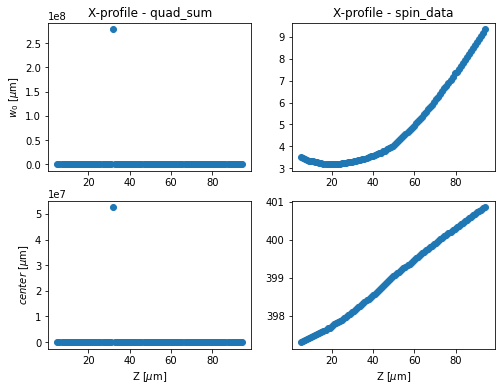

In [174]:
#draw single dataset
_, ax = plt.subplots(2,2,figsize=(8,6))

ax[0,0].scatter(ZrangeX,parX1[:,1]*2)
#ax[0,0].plot(Zrange,beamwidth_fun(Zrange,*pfitX1),'r--')
ax[0,0].set(title='X-profile - quad_sum', ylabel='$w_{0}$ [$\mu$m]')
ax[0,1].scatter(ZrangeX,parX2[:,1]*2)
#ax[0,1].plot(Zrange,beamwidth_fun(Zrange,*pfitX2),'r--')
ax[0,1].set(title='X-profile - spin_data')

ax[1,0].scatter(ZrangeX,parX1[:,0])
ax[1,0].set(xlabel='Z [$\mu$m]', ylabel='$center$ [$\mu$m]')
ax[1,1].scatter(ZrangeX,parX2[:,0])
ax[1,1].set(xlabel='Z [$\mu$m]')
ofname = folder + Fname + "_Plot.png" 

plt.savefig(ofname,dpi=300)

In [175]:
print(np.min(parX2[:,1])*2)
for i in range (0,90):
    print(i,parX2[i,1]*2)
print(ave(parX2[:,0])

3.1816841311999253
0 3.4884965098553518
1 3.440803436233192
2 3.399985929757816
3 3.3664870918122936
4 3.3391585291825594
5 3.3157065443647706
6 3.3115034284295346
7 3.2725386754516337
8 3.2596703479173414
9 3.241033318146038
10 3.2224136703966817
11 3.208679657417112
12 3.190392536267055
13 3.204350590801548
14 3.201375310206029
15 3.1816841311999253
16 3.1928961522691126
17 3.1892054599295476
18 3.1977258403542903
19 3.1965649540274086
20 3.2388712050020665
21 3.2330000106553403
22 3.2253096200363975
23 3.261128412672871
24 3.2609186256536034
25 3.295348230470008
26 3.313874645574851
27 3.3279846871801446
28 3.3517834368394905
29 3.388441266724519
30 3.415800096367072
31 3.4134902105741194
32 3.456320809236463
33 3.5030869230555792
34 3.539459651961186
35 3.5534986891444285
36 3.616635607772504
37 3.6474861271594543
38 3.7045787662608975
39 3.702956445222437
40 3.7623370309263646
41 3.800668822208714
42 3.852560917761124
43 3.907011697391892
44 3.9624891124909203
45 4.03158966029102


In [31]:
parX2[90,0]-parX2[0,0]

3.1322796226480705

In [32]:
np.average(parX2[:,0])

328.0802731039483

In [111]:
## plot y direction

In [176]:
Fname="BeamProfileY20_"
files = load_dir(folder, file_prefix = Fname, max_file=500)

100%|██████████| 91/91 [00:04<00:00, 18.67it/s]

91  files in folder
91  files loaded


In [177]:
#10 data points
parY1 = []
parY2 = []
spin=np.zeros(5000)
j=0
for ff in files:
    pos_y = ff.cant_pos[1]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data[0]
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
    parY1.append(get_waist(pos_y, quad_sum))
    parY2.append(get_waist(pos_y, spin, flip=True))
    
    if (j%10)==0:
        ofname = folder+"/" + Fname + "_Output_%d.txt" % j

        f1 = open(ofname,"a")
        for i in range(0,5000):
            f1.write('%f %e %e\n' % (pos_y[i], quad_sum[i], spin[i]))
        f1.close()
        print(j)
    j=j+1
    
parY1 = np.array(parY1)
parY2 = np.array(parY2)
ZrangeY = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

0
10
20
30
40
50
60
70
80
90


In [178]:
#100 data points
parY1 = []
parY2 = []
spin=np.zeros(5000)
j=0
for ff in files:
    pos_y = ff.cant_pos[1]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data[0]
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
#    parY1.append(get_waist(pos_y, quad_sum))
#    parY2.append(get_waist(pos_y, spin, flip=True))
    
#    if (j%10)==0:
    ofname = folder+"/" + Fname + "_Output100_%d.txt" % j

    f1 = open(ofname,"a")
    for i in range(0,5000):
        f1.write('%f %e %e\n' % (pos_y[i], quad_sum[i], spin[i]))
    f1.close()
    print(j)
    j=j+1
    
parY1 = np.array(parY1)
parY2 = np.array(parY2)
ZrangeY = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


In [179]:
#100 data points, 10 Hz
parY1 = []
parY2 = []
spin=np.zeros(5000)
j=0
for ff in files:
    pos_y = ff.cant_pos[1]
    quad_sum = ff.quad_sum
    spintemp = ff.spin_data[0]
    for i in range(0,5000):
        spin[i]=np.average(spintemp[10*i:10*i+9])
    parY1.append(get_waist(pos_y, quad_sum))
    parY2.append(get_waist(pos_y, spin, flip=True))
    
#    if (j%10)==0:
    ofname = folder+"/" + Fname + "_Output100_%d.txt" % j

    f1 = open(ofname,"a")
    for i in range(0,5000):
        f1.write('%f %e %e\n' % (pos_y[i], quad_sum[i], spin[i]))
    f1.close()
    print(j)
    j=j+1
    
parY1 = np.array(parY1)
parY2 = np.array(parY2)
ZrangeY = np.array([np.mean(ff.cant_pos[2])*10 for ff in files])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


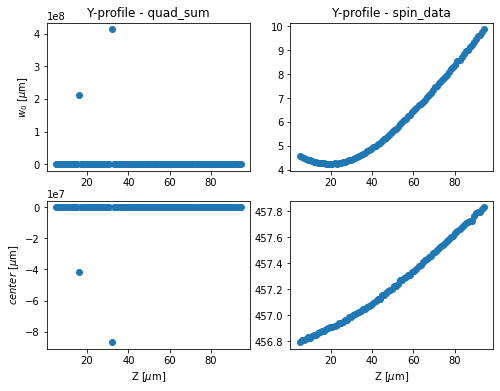

In [180]:
#draw single dataset
_, ax = plt.subplots(2,2,figsize=(8,6))

ax[0,0].scatter(ZrangeY,parY1[:,1]*2)
#ax[0,0].plot(Zrange,beamwidth_fun(Zrange,*pfitX1),'r--')
ax[0,0].set(title='Y-profile - quad_sum', ylabel='$w_{0}$ [$\mu$m]')
ax[0,1].scatter(ZrangeY,parY2[:,1]*2)
#ax[0,1].plot(Zrange,beamwidth_fun(Zrange,*pfitX2),'r--')
ax[0,1].set(title='Y-profile - spin_data')

ax[1,0].scatter(ZrangeY,parY1[:,0])
ax[1,0].set(xlabel='Z [$\mu$m]', ylabel='$center$ [$\mu$m]')
ax[1,1].scatter(ZrangeY,parY2[:,0])
ax[1,1].set(xlabel='Z [$\mu$m]')
ofname = folder + Fname + "_Plot.png" 
plt.savefig(ofname,dpi=300)

In [181]:
print(np.min(parY2[:,1])*2)
print(parY2[:,1]*2)
print(parY2[:,0])

4.231246627390208
[4.57833315 4.52392481 4.49185753 4.45725536 4.40987806 4.39464704
 4.36963179 4.33679869 4.30523529 4.29154206 4.27691939 4.26408697
 4.26931971 4.23350964 4.24624174 4.23124663 4.25281164 4.26161211
 4.25798465 4.26670822 4.27629815 4.30534623 4.32328344 4.35397165
 4.3912447  4.41203118 4.4391236  4.48567672 4.5203552  4.56570564
 4.61271528 4.64990872 4.71041784 4.76820152 4.82101394 4.85935644
 4.94329915 5.0037494  5.0790736  5.13277288 5.20986592 5.27228651
 5.34467915 5.42622415 5.50447712 5.578953   5.6665026  5.71656861
 5.7921111  5.92661275 5.99597697 6.07672032 6.13861906 6.24147733
 6.30196571 6.40102927 6.47637921 6.58660621 6.69604525 6.75505796
 6.84784847 6.91847252 7.03820494 7.11818128 7.21864952 7.32240977
 7.44022525 7.51053276 7.63250935 7.69387243 7.79589683 7.88405821
 7.97942036 8.10016704 8.20393066 8.31170822 8.3975964  8.54217687
 8.60334143 8.72938661 8.83513352 8.95237843 9.0030027  9.11317689
 9.21619029 9.34456114 9.45228182 9.57509269

In [48]:
def beamwidth_fun(t,z,w):
    return w*np.sqrt(1+((t-z)/np.pi/w/w*1.064)**2)

Zrange = np.linspace(5,95,91)

def fit_waist(pars):
    return curve_fit(beamwidth_fun, Zrange, pars[:,1],p0=[50,5])[0]

In [24]:
parY2[90,0]-parY2[0,0]

-1.4028983047234647

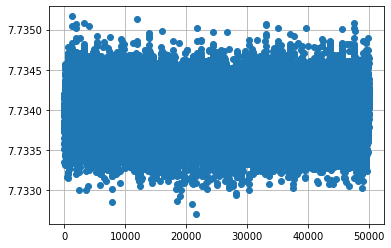

In [18]:
# plot the in-phase response
plt.plot(pos_x,linestyle="",marker="o")
#plt.ylim(-10,1)
#plt.xlim(180,270)
plt.grid(True)
plt.show()